### Objective:

Prediction of bike count required at each hour for the stable supply of rental bikes


In [3]:
from ucimlrepo import fetch_ucirepo 

import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV

from sklearn.svm import SVC, SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression

from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, root_mean_squared_error
from sklearn.inspection import DecisionBoundaryDisplay

from time import time
from IPython.display import display

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [4]:
# Fetch the bike sharing demand dataset
bike_share = fetch_ucirepo(id=560) 

# Extract data in original form, features and targets
bike_share_df = bike_share.data.original
bike_share_x = bike_share.data.features 
bike_share_y = bike_share.data.targets 
  
# Show metadata 
bike_share_metadata = bike_share.metadata
for key, value in bike_share_metadata.items():
    print(f"{key} : {value}")

# Show variable information
bike_share_variables = bike_share.variables
display(bike_share_variables)


uci_id : 560
name : Seoul Bike Sharing Demand
repository_url : https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand
data_url : https://archive.ics.uci.edu/static/public/560/data.csv
abstract : The dataset contains count of public bicycles rented per hour in the Seoul Bike Sharing System, with corresponding weather data and holiday information
area : Business
tasks : ['Regression']
characteristics : ['Multivariate']
num_instances : 8760
num_features : 13
feature_types : ['Integer', 'Real']
demographics : []
target_col : ['Functioning Day']
index_col : None
has_missing_values : no
missing_values_symbol : None
year_of_dataset_creation : 2020
last_updated : Mon Feb 05 2024
dataset_doi : 10.24432/C5F62R
creators : []
intro_paper : None
additional_info : {'summary': 'Currently Rental bikes are introduced in many urban cities for the enhancement of mobility comfort. It is important to make the rental bike available and accessible to the public at the right time as it lessens the 

,name,role,type,demographic,description,units,missing_values
0,Date,Feature,Date,None,None,None,no
1,Rented Bike Count,Feature,Integer,None,None,None,no
2,Hour,Feature,Integer,None,None,None,no
3,Temperature,Feature,Continuous,None,None,C,no
4,Humidity,Feature,Integer,None,None,%,no
5,Wind speed,Feature,Continuous,None,None,m/s,no
6,Visibility,Feature,Integer,None,None,10m,no
7,Dew point temperature,Feature,Continuous,None,None,C,no
8,Solar Radiation,Feature,Continuous,None,None,Mj/m2,no
9,Rainfall,Feature,Integer,None,None,mm,no


In [5]:
# Check info
bike_share_df.info()
bike_share_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   8760 non-null   object 
 1   Rented Bike Count      8760 non-null   int64  
 2   Hour                   8760 non-null   int64  
 3   Temperature            8760 non-null   float64
 4   Humidity               8760 non-null   int64  
 5   Wind speed             8760 non-null   float64
 6   Visibility             8760 non-null   int64  
 7   Dew point temperature  8760 non-null   float64
 8   Solar Radiation        8760 non-null   float64
 9   Rainfall               8760 non-null   float64
 10  Snowfall               8760 non-null   float64
 11  Seasons                8760 non-null   object 
 12  Holiday                8760 non-null   object 
 13  Functioning Day        8760 non-null   object 
dtypes: float64(6), int64(4), object(4)
memory usage: 958.2+ 

,Date,Rented Bike Count,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day
0,1/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,1/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,1/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,1/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [6]:
# Check Shape
print(f"Bike Share Data: {bike_share_df.shape}")
print(f"Bike Share Features: {bike_share_x.shape}")
print(f"Bike Share Target: {bike_share_y.shape}\n")

# Check for missing values and duplicates

energy_eff_null = bike_share_df.isnull().sum()
print(f"Number of missing values in dataframe: {energy_eff_null.sum()}\n")

energy_eff_dups = bike_share_df.duplicated().sum()
print(f"Number of duplicate rows in dataframe: {energy_eff_dups}\n")

# Check for unique values in each column

bike_share_columns = bike_share_df.columns
print("Number of unique values per column:")
for column in bike_share_columns:
    print(f"{column} -  {bike_share_df[column].nunique()}")

Bike Share Data: (8760, 14)
Bike Share Features: (8760, 13)
Bike Share Target: (8760, 1)

Number of missing values in dataframe: 0

Number of duplicate rows in dataframe: 0

Number of unique values per column:
Date -  365
Rented Bike Count -  2166
Hour -  24
Temperature -  546
Humidity -  90
Wind speed -  65
Visibility -  1789
Dew point temperature -  556
Solar Radiation -  345
Rainfall -  61
Snowfall -  51
Seasons -  4
Holiday -  2
Functioning Day -  2


In [7]:
# Check frequency of unique values in specific columns

bike_share_investigate = ["Seasons", "Holiday", "Functioning Day"]
for column in bike_share_investigate:
    print(f"{column}")
    print(bike_share_df[column].value_counts(ascending=False))
    print("\n")

Seasons
Spring    2208
Summer    2208
Autumn    2184
Winter    2160
Name: Seasons, dtype: int64


Holiday
No Holiday    8328
Holiday        432
Name: Holiday, dtype: int64


Functioning Day
Yes    8465
No      295
Name: Functioning Day, dtype: int64




In [8]:
# Extract Winter data
bike_share_fin_df = bike_share_df[bike_share_df["Seasons"]=="Winter"]
bike_share_fin_df.head()

,Date,Rented Bike Count,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day
0,1/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,1/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,1/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,1/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [9]:
# Extract only the weather data + hour of the day 
bike_share_fin_columns = ["Rented Bike Count", "Hour", "Temperature", "Humidity", "Wind speed", "Visibility",
                          "Dew point temperature", "Solar Radiation", "Rainfall", "Snowfall"]
bike_share_fin_df = bike_share_fin_df[bike_share_fin_columns]

bike_share_fin_df.head()

,Rented Bike Count,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0


In [10]:
# Show numerical statistics of the data
bike_share_fin_df.describe()

,Rented Bike Count,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall
count,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000
mean,225.541204,11.500000,-2.540463,49.744907,1.922685,1445.987037,-12.416667,0.298181,0.032824,0.247500
std,150.372236,6.923789,5.469763,19.303054,1.156028,634.856446,7.715812,0.523243,0.422526,0.698369
min,3.000000,0.000000,-17.800000,14.000000,0.000000,54.000000,-30.600000,0.000000,0.000000,0.000000
25%,110.000000,5.750000,-6.200000,34.000000,1.000000,953.750000,-18.600000,0.000000,0.000000,0.000000
50%,203.000000,11.500000,-2.200000,47.000000,1.700000,1762.000000,-13.000000,0.000000,0.000000,0.000000
75%,305.000000,17.250000,1.500000,63.000000,2.700000,1998.000000,-6.200000,0.452500,0.000000,0.000000
max,937.000000,23.000000,10.300000,97.000000,6.700000,2000.000000,4.200000,2.520000,9.500000,5.100000


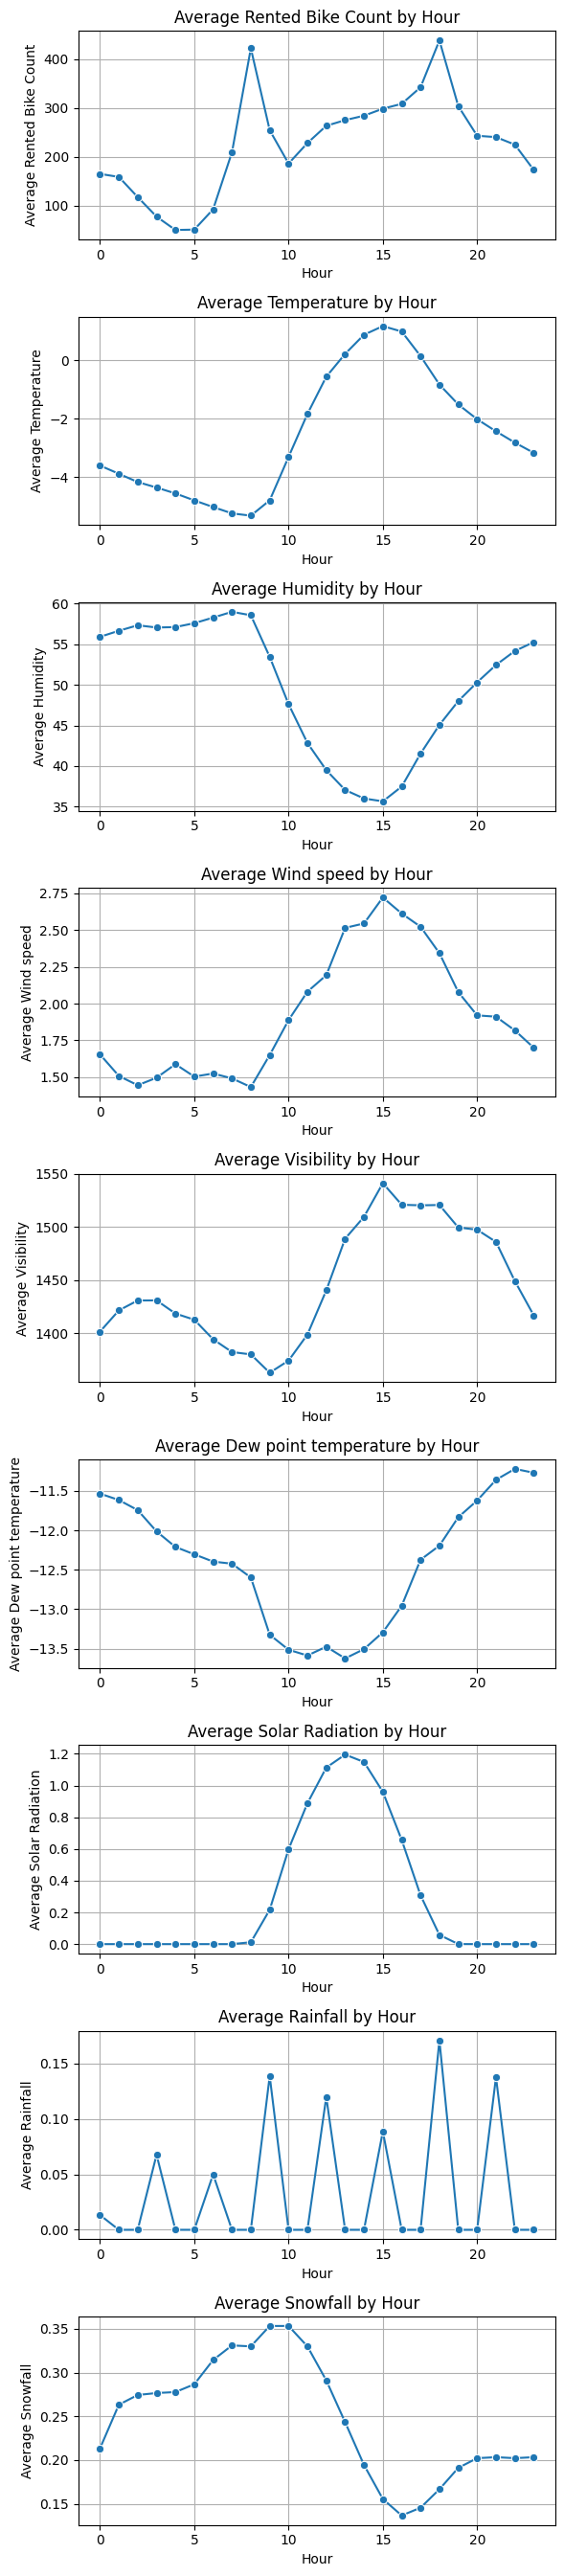

In [11]:
columns = ["Rented Bike Count", "Temperature", "Humidity", "Wind speed", "Visibility",
                          "Dew point temperature", "Solar Radiation", "Rainfall", "Snowfall"]

fig, axs = plt.subplots(len(columns), 1, figsize=(6, 3*len(columns)))

# Loop over the columns
for i, column in enumerate(columns):
    # Calculate the average for the current column
    average_by_hour = bike_share_fin_df.groupby('Hour')[column].mean()

    # Create a line plot for the current column
    sns.lineplot(x=average_by_hour.index, y=average_by_hour.values, marker='o', ax=axs[i])
    axs[i].set_xlabel('Hour')
    axs[i].set_ylabel(f'Average {column}')
    axs[i].set_title(f'Average {column} by Hour')
    axs[i].grid(True)

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

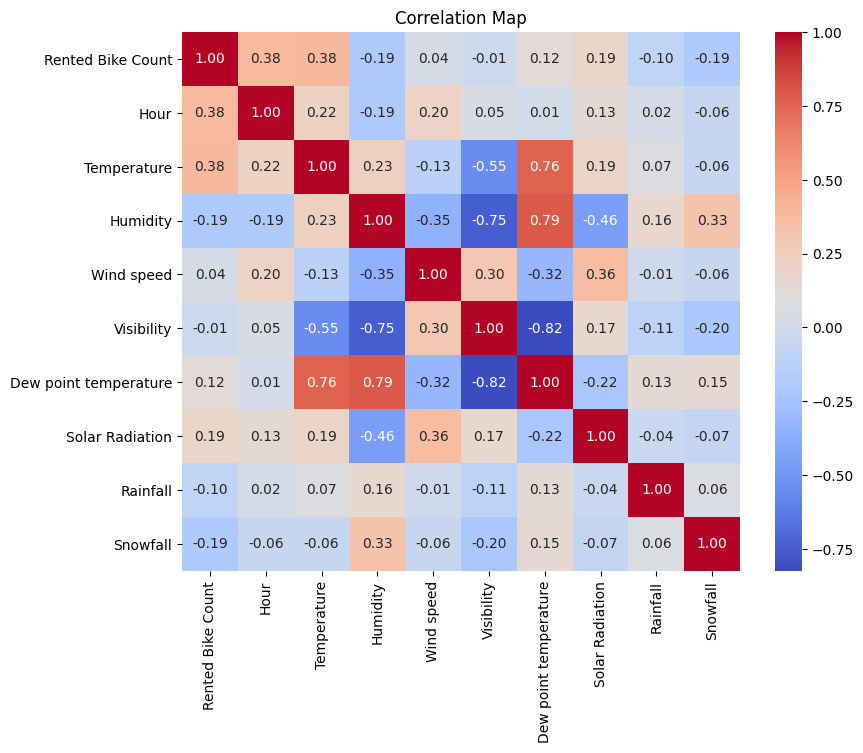

In [12]:
corr = bike_share_fin_df.corr()

# Create a heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Map')
plt.show()

<mark> Visualize the weather data and the rented bike count using box plots </mark>

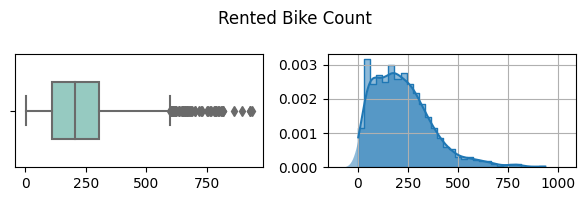

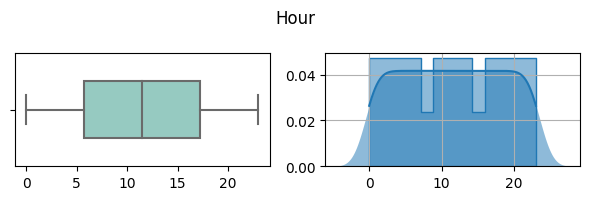

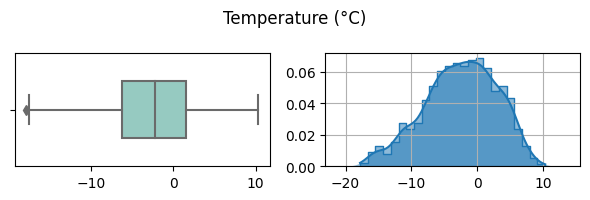

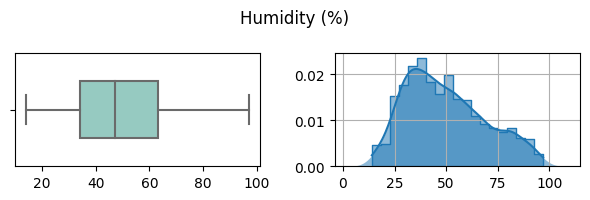

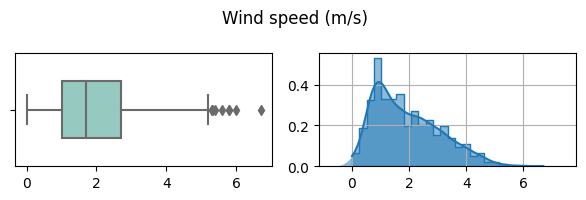

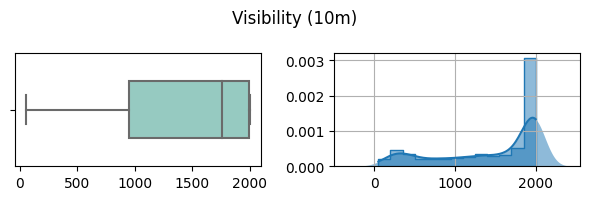

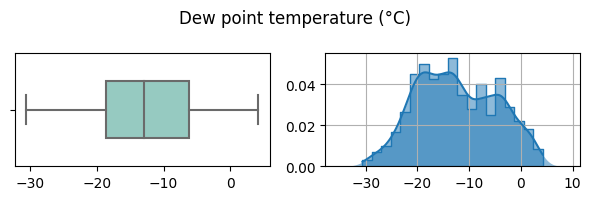

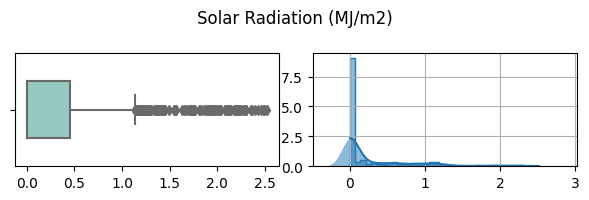

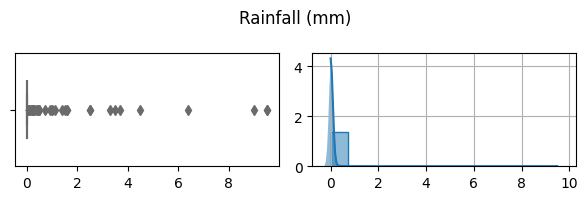

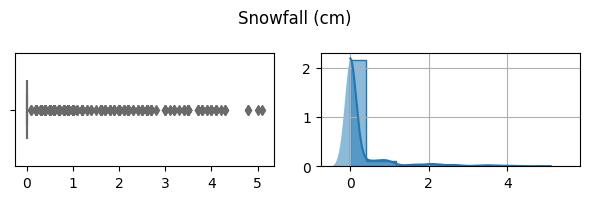

In [13]:
# Display box plot and histogram of each column

bike_share_fin_name = ["Rented Bike Count", "Hour", "Temperature (°C)", "Humidity (%)", "Wind speed (m/s)", "Visibility (10m)",
                          "Dew point temperature (°C)", "Solar Radiation (MJ/m2)", "Rainfall (mm)", "Snowfall (cm)"]

for i, column in enumerate(bike_share_fin_columns):
    fig, ax = plt.subplots(1, 2, figsize=(6, 2))

    # Create a box plot of the column
    sns.boxplot(x=bike_share_fin_df[column], ax=ax[0], width=0.5, showfliers=True, palette='Set3')
    ax[0].set(xlabel=None, ylabel=None)

    # Create a histogram of the column
    sns.histplot(data=bike_share_fin_df, x=column, element="step", stat="density", common_norm=False, ax=ax[1], kde=True)
    sns.kdeplot(data=bike_share_fin_df, x=column,fill=True, common_norm=False, alpha=.5, linewidth=0, ax=ax[1])
    ax[1].set(xlabel=None, ylabel=None)
    ax[1].grid(True) 

    plt.suptitle(bike_share_fin_name[i])
    plt.subplots_adjust(wspace=0.5)
    plt.tight_layout()
    plt.show()

<mark> Standard Scaler and SVR with Hyperparameter Tuning </mark>

In [14]:
# Separate the data into features and target

print(f"Columns: {bike_share_fin_df.columns}")
bike_share_y_ = bike_share_fin_df.iloc[:, 0]
bike_share_x_ = bike_share_fin_df.iloc[:, 1:]

print(f"Feature Shape: {bike_share_x_.shape}")
print(f"Target Shape: {bike_share_y_.shape}")


Columns: Index(['Rented Bike Count', 'Hour', 'Temperature', 'Humidity', 'Wind speed',
       'Visibility', 'Dew point temperature', 'Solar Radiation', 'Rainfall',
       'Snowfall'],
      dtype='object')
Feature Shape: (2160, 9)
Target Shape: (2160,)


In [15]:
# Split data into train and test set

bike_x_train, bike_x_test, bike_y_train, bike_y_test = train_test_split(bike_share_x_ , bike_share_y_, 
                                                                test_size=0.30, random_state=42)
print(f"X Train Shape: {bike_x_train.shape}")
print(f"Y Train Shape: {bike_y_train.shape}")
print(f"X Test Shape: {bike_x_test.shape}")
print(f"Y Test Shape: {bike_y_test.shape}")

X Train Shape: (1512, 9)
Y Train Shape: (1512,)
X Test Shape: (648, 9)
Y Test Shape: (648,)


In [16]:
# Train an SVR model and perform hyperparameter tuning

bike_svr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVR())]).fit(bike_x_train, bike_y_train)

bike_svr_param = {
    "model__kernel": ["linear", "poly", "rbf", "sigmoid"],
    "model__C": [0.01, 0.1, 1, 10, 100],
    "model__epsilon": [0.01, 0.1, 1]}

bike_svr_search = RandomizedSearchCV(bike_svr_pipeline, bike_svr_param, scoring="neg_root_mean_squared_error",
                                     cv=5, verbose=2, n_jobs=-1, random_state=42)

start = time()
bike_svr_search.fit(bike_x_train, bike_y_train)
bike_svr_t = (time() - start)
print("RandomizedSearchCV took %.2f seconds."
        % (bike_svr_t))

bike_svr_best_params = bike_svr_search.best_params_
bike_svr_best_pipeline = bike_svr_search.best_estimator_

display(bike_svr_best_params)
display(bike_svr_best_pipeline)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomizedSearchCV took 8.19 seconds.


{'model__kernel': 'rbf', 'model__epsilon': 0.1, 'model__C': 100}

Pipeline(steps=[('scaler', StandardScaler()), ('model', SVR(C=100))])

In [17]:
# Evaluate the initial and best SVR model

bike_svr_init_pred = bike_svr_pipeline.predict(bike_x_test)
bike_svr_init_rmse = root_mean_squared_error(bike_y_test, bike_svr_init_pred)

bike_svr_best_pred = bike_svr_best_pipeline.predict(bike_x_test)
bike_svr_best_rmse = root_mean_squared_error(bike_y_test, bike_svr_best_pred)

bike_svr_evaluation = {
    "Model Name": ["SVR", "SVR"],
    "Model Parameters": ["Default", "Tuned"],
    "RMSE": [bike_svr_init_rmse, bike_svr_best_rmse]}

bike_svr_evaluation = pd.DataFrame(bike_svr_evaluation)
bike_svr_evaluation = bike_svr_evaluation.round({"RMSE": 2})
display(bike_svr_evaluation)

,Model Name,Model Parameters,RMSE
0,SVR,Default,127.07
1,SVR,Tuned,112.88


<mark> Standard Scaler and KRR with Hyperparameter Tuning </mark>

In [18]:
# Train a Linear KRR model and perform hyperparameter tuning

bike_krr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", KernelRidge(kernel='linear'))]).fit(bike_x_train, bike_y_train)

bike_krr_param = {
    'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__kernel': ['linear', 'poly', 'rbf'],
    'model__degree': [2, 3, 4]}

bike_krr_search = RandomizedSearchCV(bike_krr_pipeline, bike_krr_param, scoring="neg_root_mean_squared_error",
                                     cv=5, verbose=2, n_jobs=-1, random_state=42)

start = time()
bike_krr_search.fit(bike_x_train, bike_y_train)
print("RandomizedSearchCV took %.2f seconds."
        % (time() - start))

bike_krr_best_params = bike_krr_search.best_params_
bike_krr_best_pipeline = bike_krr_search.best_estimator_

display(bike_krr_best_params)
display(bike_krr_best_pipeline)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomizedSearchCV took 2.89 seconds.


{'model__kernel': 'rbf', 'model__degree': 4, 'model__alpha': 0.01}

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', KernelRidge(alpha=0.01, degree=4, kernel='rbf'))])

In [19]:
# Evaluate the initial and best KRR model
bike_krr_init_pred = bike_krr_pipeline.predict(bike_x_test)
bike_krr_init_rmse = root_mean_squared_error(bike_y_test, bike_krr_init_pred)

bike_krr_best_pred = bike_krr_best_pipeline.predict(bike_x_test)
bike_krr_best_rmse = root_mean_squared_error(bike_y_test, bike_krr_best_pred)

bike_krr_evaluation = {
    "Model Name": ["KRR", "KRR"],
    "Model Parameters": ["Default", "Tuned"],
    "RMSE": [bike_krr_init_rmse, bike_krr_best_rmse]}

bike_krr_evaluation = pd.DataFrame(bike_krr_evaluation)
bike_krr_evaluation = bike_krr_evaluation.round({"RMSE": 2})
display(bike_krr_evaluation)

,Model Name,Model Parameters,RMSE
0,KRR,Default,253.39
1,KRR,Tuned,100.78


<mark> Linear Regression with Hyperparameter Tuning </mark>

In [20]:
# Train a simple Linear Regression model and perform hyperparameter tuning

bike_lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())]).fit(bike_x_train, bike_y_train)

bike_lr_param = {
    "model__fit_intercept": [True, False]}

bike_lr_search = RandomizedSearchCV(bike_lr_pipeline, bike_lr_param, scoring="neg_root_mean_squared_error",
                                     cv=5, verbose=2, n_jobs=-1, random_state=42)

start = time()
bike_lr_search.fit(bike_x_train, bike_y_train)
print("RandomizedSearchCV took %.2f seconds."
        % (time() - start))

bike_lr_best_params = bike_lr_search.best_params_
bike_lr_best_pipeline = bike_lr_search.best_estimator_

display(bike_lr_best_params)
display(bike_lr_best_pipeline)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
RandomizedSearchCV took 0.13 seconds.


c:\Users\maryn\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'model__fit_intercept': True}

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [21]:
# Evaluate the initial and best Linear Regression model

bike_lr_init_pred = bike_lr_pipeline.predict(bike_x_test)
bike_lr_init_rmse = root_mean_squared_error(bike_y_test, bike_lr_init_pred)

bike_lr_best_pred = bike_lr_best_pipeline.predict(bike_x_test)
bike_lr_best_rmse = root_mean_squared_error(bike_y_test, bike_lr_best_pred)

bike_lr_evaluation = {
    "Model Name": ["Linear Regression", "Linear Regression"],
    "Model Parameters": ["Default", "Tuned"],
    "RMSE": [bike_lr_init_rmse, bike_lr_best_rmse]}

bike_lr_evaluation = pd.DataFrame(bike_lr_evaluation)
bike_lr_evaluation = bike_lr_evaluation.round({"RMSE": 2})
display(bike_lr_evaluation)

,Model Name,Model Parameters,RMSE
0,Linear Regression,Default,120.29
1,Linear Regression,Tuned,120.29


In [22]:
# Compare the evaluation of the models
bike_evaluation = pd.concat([bike_svr_evaluation, bike_krr_evaluation, bike_lr_evaluation])
bike_evaluation = bike_evaluation.sort_values(by="RMSE", ascending=True)
bike_evaluation = bike_evaluation.reset_index(drop=True)
display(bike_evaluation)

,Model Name,Model Parameters,RMSE
0,KRR,Tuned,100.78
1,SVR,Tuned,112.88
2,Linear Regression,Default,120.29
3,Linear Regression,Tuned,120.29
4,SVR,Default,127.07
5,KRR,Default,253.39


## Summary Insights

- KRR model with hyperparameter tuning performed the best out of all the models
- Without hyperparameter tuning, linear regression model performed the best out of all the models.